### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [124]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F # Contiene una versione funzionale di molti layer. 
import torchvision.transforms as transforms
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [125]:
# Hyperparameters
eval_percentage = 0.3
lr = 0.0001
opt = 'Adam'
loss = 'CrossEntropy'
epochs = 25
#layers = [28*28, 64, 64, 64, 10]
layers = [28*28, 64, 64, 64, 128, 64, 64, 64, 10]
batch_size = 64



In [126]:
# Data import
def import_MNIST():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Numeri per fare la standardizzazione di MNIST si ottengono come sotto
    ])
    
    
    
    train_data = MNIST(root='./data', train=True, download=True, transform=transform)
    eval_size = round(eval_percentage*(len(train_data)))
    eval_data = Subset(train_data, range(eval_size))
    train_data = Subset(train_data, range(eval_size, len(train_data)))
    test_data = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=4)
    evaluation   = torch.utils.data.DataLoader(eval_data, batch_size, num_workers=4)
    test  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True, num_workers=4)

    
    return train, evaluation, test

In [127]:
class simpleMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        for i in range(len(layer_sizes)-1):
            self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes)-2:
                self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())

    def forward(self, x):
        return self.layers(x)

In [128]:
model1 = simpleMLP(layers)
print(model1)

simpleMLP(
  (layers): Sequential(
    (layer-flatten): Flatten(start_dim=1, end_dim=-1)
    (layer-0): Linear(in_features=784, out_features=64, bias=True)
    (Nonlinearity-layer-0): ReLU()
    (layer-1): Linear(in_features=64, out_features=64, bias=True)
    (Nonlinearity-layer-1): ReLU()
    (layer-2): Linear(in_features=64, out_features=64, bias=True)
    (Nonlinearity-layer-2): ReLU()
    (layer-3): Linear(in_features=64, out_features=128, bias=True)
    (Nonlinearity-layer-3): ReLU()
    (layer-4): Linear(in_features=128, out_features=64, bias=True)
    (Nonlinearity-layer-4): ReLU()
    (layer-5): Linear(in_features=64, out_features=64, bias=True)
    (Nonlinearity-layer-5): ReLU()
    (layer-6): Linear(in_features=64, out_features=64, bias=True)
    (Nonlinearity-layer-6): ReLU()
    (layer-7): Linear(in_features=64, out_features=10, bias=True)
  )
)


### Riscrivere plot

In [129]:
def evaluate(model, dl, device='cpu'):
    model.eval()
    predictions = []
    ground_truth = [] 
    for (value, label) in tqdm(dl, desc='Evaluating', leave=True):
        value = value.to(device)
        prediction = torch.argmax(model(value), dim=1)

        ground_truth = np.append(ground_truth, label.cpu().numpy())  
        predictions = np.append(predictions, prediction.detach().cpu().numpy()) 


    accuracy = accuracy_score(ground_truth, predictions)
    report = classification_report(ground_truth, predictions, zero_division=0, digits=3)
        
    
    return (accuracy, report)

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

In [134]:
def train_batch(epoch, model, optimizer, loss_fn, train_data, device, writer):
    losses = []
    for (value, label) in tqdm(train_data, desc=f'Training epoch {epoch}', leave=True):
        value = value.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        prediction = model(value)
        
        # Choose loss function
        if loss == 'CrossEntropy':
            loss_fn = nn.CrossEntropyLoss()
            
        loss_value = loss_fn(prediction, label)
        loss_value.backward()
        optimizer.step()
        losses.append(loss_value.item())

        writer.add_scalar('Loss/train', np.mean(losses), epoch)
        
    return np.mean(losses)

def train_model(model, optimizer, loss, epochs, train_data, eval_data, device, writer):
    model.train()
    losses_and_accs = []
    for epoch in range(epochs):
        loss_value = train_batch(epoch, model, optimizer, loss, train_data, device, writer)
        (accuracy, _) = evaluate(model, eval_data, device)
        losses_and_accs.append((loss_value, accuracy))
        #losses_and_accs.append(loss_value)
        writer.add_scalar('Accuracy/train', accuracy, epoch)
    return losses_and_accs

            

In [135]:
# Main function
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(train_data, eval_data, test_data) = import_MNIST()


# Instance of the model
model = simpleMLP(layers)
model.to(device)
#print(model)

# Choose optimizer
if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

writer = SummaryWriter(log_dir=f"runs/MNIST-model='MLP'-lr={lr}-opt={opt}-loss={loss}-epochs={epochs}-batch_size={batch_size}")

losses_and_accs = train_model(model, optimizer, loss, epochs, train_data, eval_data, device, writer)



Evaluating: 100%|████████████████████████████| 282/282 [00:02<00:00, 116.92it/s]


0.05868806001089536


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 67.62it/s]

Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.969     0.982     0.975       980
         1.0      0.977     0.992     0.985      1135
         2.0      0.940     0.959     0.950      1032
         3.0      0.928     0.951     0.939      1010
         4.0      0.950     0.961     0.955       982
         5.0      0.965     0.925     0.944       892
         6.0      0.987     0.951     0.969       958
         7.0      0.932     0.966     0.949      1028
         8.0      0.960     0.897     0.928       974
         9.0      0.923     0.933     0.928      1009

    accuracy                          0.953     10000
   macro avg      0.953     0.952     0.952     10000
weighted avg      0.953     0.953     0.953     10000



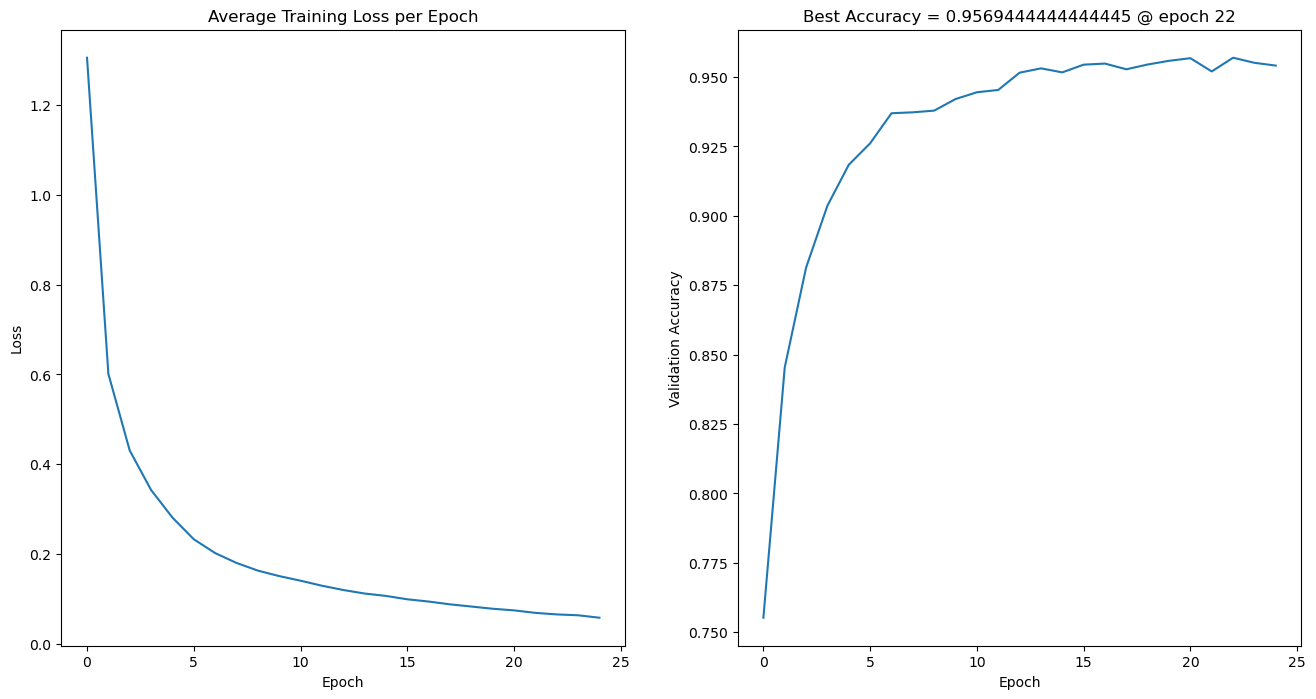

In [136]:
#Testing model
print(np.min(losses_and_accs))
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate(model, test_data, device=device)[1]}')

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [137]:
# Non funziona se i layer intermedi hanno dimensioni diverse. Risolvere
class skipMLPBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.layer1 = nn.Linear(in_size, out_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(out_size, in_size)

    def forward(self, x):
        out1 = self.layer1(x)
        out1_relu = self.relu1(out1)
        out2 = self.layer2(out1_relu)

        out = x + out2
            
        return out

class skipMLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module(f'layer-flatten', nn.Flatten())
        
        for i in range(len(layer_sizes)-1):
            if i == 0:
                self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            elif i == len(layer_sizes)-2:
                self.layers.add_module(f'layer-{i}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            else:
                self.layers.add_module(f'layer-{i}', skipMLPBlock(layer_sizes[i], layer_sizes[i+1]))
                if layer_sizes[i] != layer_sizes[i+1]:
                    self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())
                    self.layers.add_module(f'layer-bridge{i}-{i+1}', nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                    self.layers.add_module(f'Nonlinearity-bridge{i}-{i+1}', nn.ReLU())
            if i < len(layer_sizes)-2:
                    self.layers.add_module(f'Nonlinearity-layer-{i}', nn.ReLU())

    def forward(self, x):
        return self.layers(x)

modelres = skipMLP(layers)
print(modelres)

skipMLP(
  (layers): Sequential(
    (layer-flatten): Flatten(start_dim=1, end_dim=-1)
    (layer-0): Linear(in_features=784, out_features=64, bias=True)
    (Nonlinearity-layer-0): ReLU()
    (layer-1): skipMLPBlock(
      (layer1): Linear(in_features=64, out_features=64, bias=True)
      (relu1): ReLU()
      (layer2): Linear(in_features=64, out_features=64, bias=True)
    )
    (Nonlinearity-layer-1): ReLU()
    (layer-2): skipMLPBlock(
      (layer1): Linear(in_features=64, out_features=64, bias=True)
      (relu1): ReLU()
      (layer2): Linear(in_features=64, out_features=64, bias=True)
    )
    (Nonlinearity-layer-2): ReLU()
    (layer-3): skipMLPBlock(
      (layer1): Linear(in_features=64, out_features=128, bias=True)
      (relu1): ReLU()
      (layer2): Linear(in_features=128, out_features=64, bias=True)
    )
    (Nonlinearity-layer-3): ReLU()
    (layer-bridge3-4): Linear(in_features=64, out_features=128, bias=True)
    (Nonlinearity-bridge3-4): ReLU()
    (layer-4): skip

In [139]:
# Main function 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(train_data, eval_data, test_data) = import_MNIST()

# Instance of the model
modelskip = skipMLP(layers)
modelskip.to(device)
#print(model)

# Choose optimizer
if opt == 'Adam':
    optimizer = torch.optim.Adam(modelskip.parameters(), lr=lr)
    
writer = SummaryWriter(log_dir=f"runs/MNIST-model='skipMLP'-lr={lr}-opt={opt}-loss={loss}-epochs={epochs}-batch_size={batch_size}")

losses_and_accs = train_model(modelskip, optimizer, loss, epochs, train_data, eval_data, device, writer)

Evaluating: 100%|████████████████████████████| 282/282 [00:02<00:00, 113.29it/s]


0.023573912434339102


Evaluating: 100%|█████████████████████████████| 157/157 [00:02<00:00, 66.29it/s]

Accuracy report on TEST:
               precision    recall  f1-score   support

         0.0      0.969     0.982     0.975       980
         1.0      0.977     0.992     0.985      1135
         2.0      0.940     0.959     0.950      1032
         3.0      0.928     0.951     0.939      1010
         4.0      0.950     0.961     0.955       982
         5.0      0.965     0.925     0.944       892
         6.0      0.987     0.951     0.969       958
         7.0      0.932     0.966     0.949      1028
         8.0      0.960     0.897     0.928       974
         9.0      0.923     0.933     0.928      1009

    accuracy                          0.953     10000
   macro avg      0.953     0.952     0.952     10000
weighted avg      0.953     0.953     0.953     10000



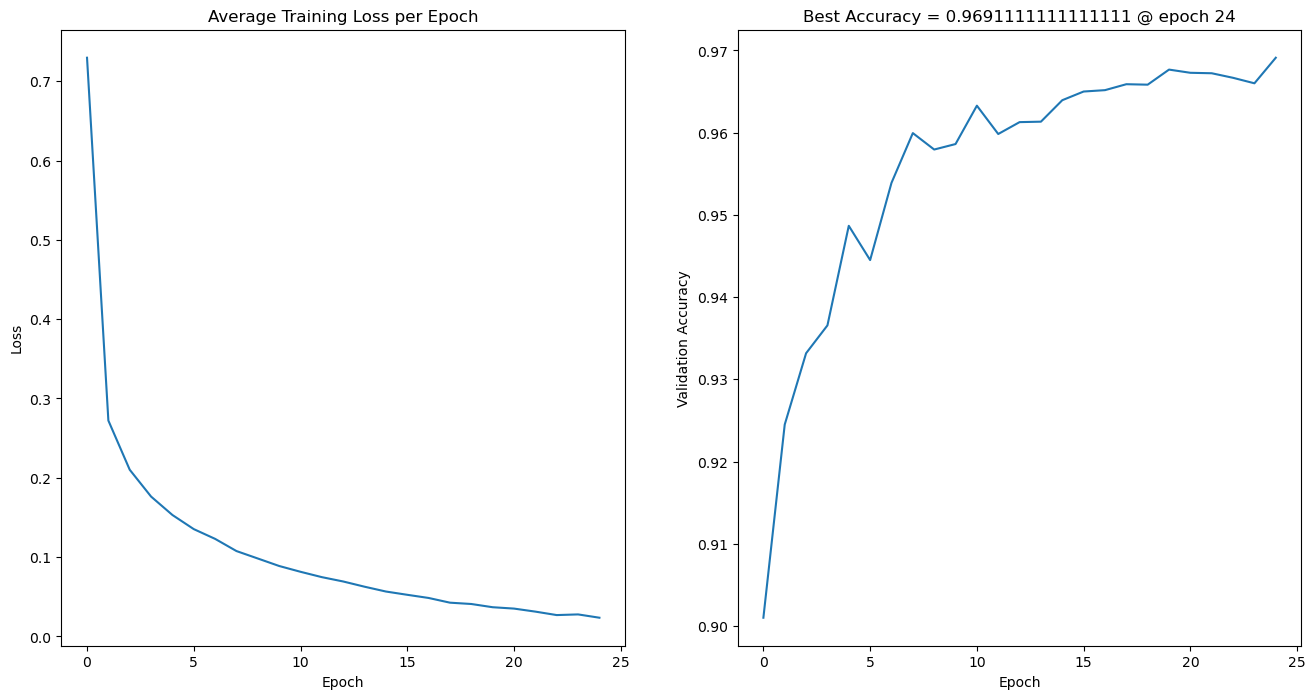

In [140]:
#Testing model
print(np.min(losses_and_accs))
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate(model, test_data, device=device)[1]}')

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [145]:
conv_layers = [
    (64, 3, 1, 1),  # in_ch, out_ch, kernel, stride, padding
    (64, 3, 1, 1), 
    (64, 3, 1, 1),
    (128, 1, 1, 1),
    (10, 1, 1, 1)
]


class simpleCONV(nn.Module):
    def __init__(self, conv_layers):
        super().__init__()
        self.layers = nn.Sequential()
        #self.layers.add_module(f'layer-flatten', nn.Flatten())
        in_channels = 1
        for i, layer in enumerate(conv_layers):
            out_channels, kernel, stride, padding = layer
            self.layers.add_module(f'conv_layer-{i}', nn.Conv2d(in_channels, out_channels, kernel, stride, padding))
            in_channels = out_channels 
            if i < len(conv_layers)-1:
                self.layers.add_module(f'relu-{i}', nn.ReLU())
            else:
                self.layers.add_module(f'classification-{i}', nn.AdaptiveMaxPool2d((1, 1)))
                
            if kernel != 1: 
                self.layers.add_module(f'Max_pooling-{i}', nn.MaxPool2d(kernel_size=2, stride=2))


    def forward(self, x):
        return self.layers(x)

modelres = simpleCONV(conv_layers)
print(modelres)

simpleCONV(
  (layers): Sequential(
    (conv_layer-0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-0): ReLU()
    (Max_pooling-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_layer-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-1): ReLU()
    (Max_pooling-1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_layer-2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu-2): ReLU()
    (Max_pooling-2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_layer-3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (relu-3): ReLU()
    (conv_layer-4): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (classification-4): AdaptiveMaxPool2d(output_size=(1, 1))
  )
)


In [147]:
# Main function 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

(train_data, eval_data, test_data) = import_MNIST()

# Instance of the model
modelconv = simpleCONV(conv_layers)
modelconv.to(device)
#print(model)

# Choose optimizer
if opt == 'Adam':
    optimizer = torch.optim.Adam(modelconv.parameters(), lr=lr)

losses_and_accs = train_model(modelconv, optimizer, loss, epochs, train_data, eval_data, device, writer)

Training epoch 0:   0%|                                 | 0/657 [00:02<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[64, 1, 28, 28] to have 3 channels, but got 1 channels instead

0.04266846880793027


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.977     0.983     0.980       980
           1      0.986     0.986     0.986      1135
           2      0.987     0.964     0.975      1032
           3      0.954     0.976     0.965      1010
           4      0.969     0.970     0.970       982
           5      0.958     0.971     0.964       892
           6      0.963     0.980     0.972       958
           7      0.970     0.969     0.969      1028
           8      0.965     0.954     0.959       974
           9      0.976     0.952     0.964      1009

    accuracy                          0.971     10000
   macro avg      0.970     0.971     0.970     10000
weighted avg      0.971     0.971     0.971     10000



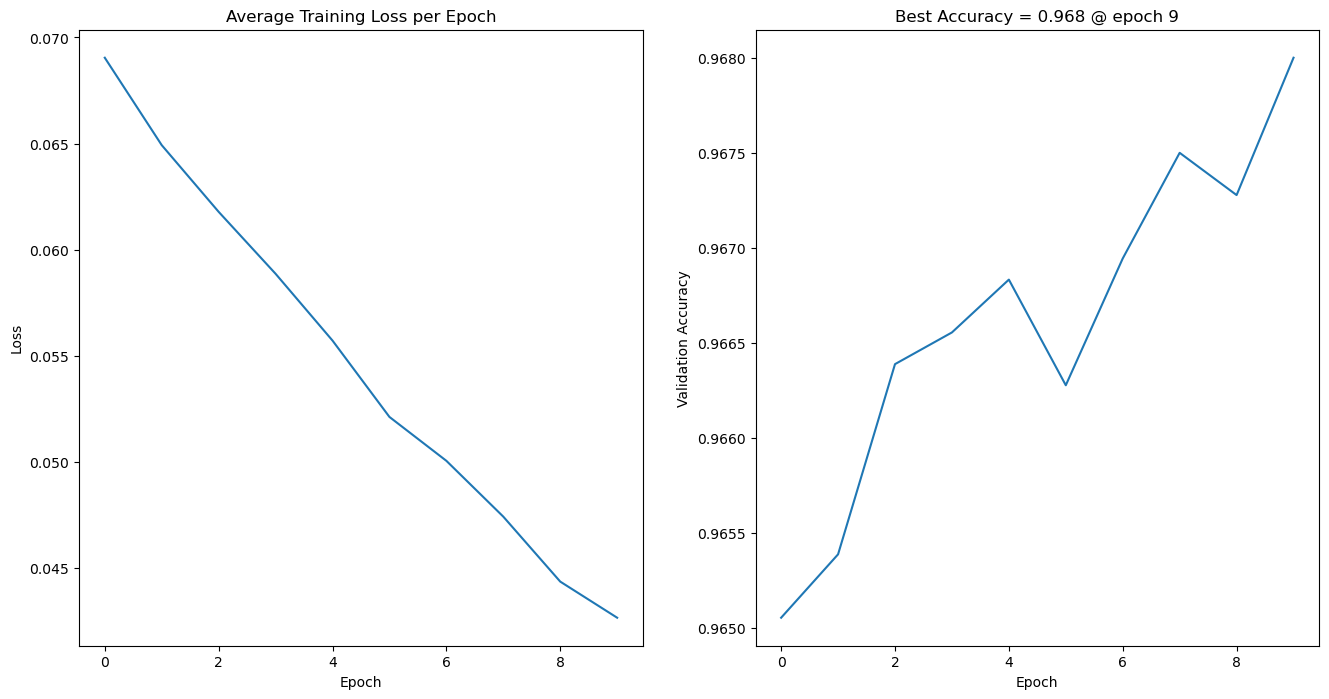

In [27]:
#Testing model
print(np.min(losses_and_accs))
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate(model, test_data, device=device)[1]}')

In [1]:
def visualize_filters(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            # Recuperiamo i pesi del filtro (weights)
            filters = module.weight.data.clone().cpu()
            num_filters = filters.size(0)
            
            # Determina la dimensione del filtro
            fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
            for i in range(num_filters):
                ax = axes[i] if num_filters > 1 else axes
                ax.imshow(filters[i].squeeze().numpy(), cmap='gray')
                ax.axis('off')
            plt.show()

# Visualizzare i filtri
visualize_filters(modelskip)

NameError: name 'modelskip' is not defined

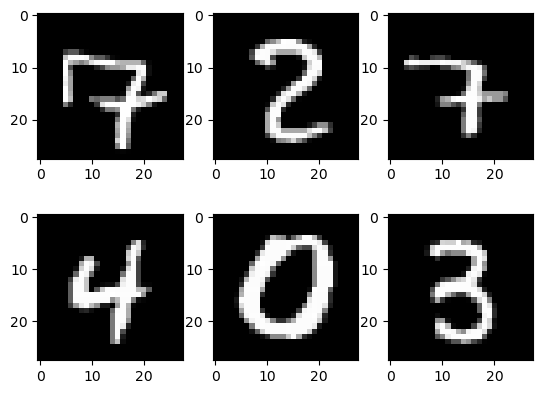

In [106]:
# Tensorboard test
examples = iter(test_data)
example_data, example_target = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)
writer.close()
